# HITO 2 – Análisis de Datos y Formulación del Problema
## Reconocimiento y Clasificación de Tumores Cerebrales – Desarrollo e Integración de Servicios de IA

### 1. Carga de los datos

In [13]:
import zipfile
import os

# Usamos una ruta relativa (sin la barra inicial /)
local_zip = './content/bbdd_tumors.zip' 
random_state=42 # para la reproducibilidad
if os.path.exists(local_zip):
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall('./content')
        zip_ref.close()
        base_dir = '/content/Data'
else:
    print(f"Error: No existe la ruta {os.path.abspath(local_zip)}")

In [ ]:
# Estas son los nombres de las carpetas que hay en el zip, y se corresponden con las 4 clases que hay
clases = ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'normal']

Para realizar el análisis de los datos, vamos a realizar una división train, validación y test con la librería splitfolders con el fin de no cometer fuga de datos al analizar los datos, puesto que no se incluye esta división en la base de datos que hemos descargado. Para ello, dedicaremos el 60% de las imágenes al train, el 20% a la validación, y el 20% restante al test.

In [6]:
!pip install split-folders
import splitfolders

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [23]:
from pathlib import Path
input = Path(base_dir) # Directory to split
output = Path(".") / "data" # New directory
seed = 42 #to obtain always the same partition
train_size = 0.6    # Fraction for train
val_size = 0.2 #Fraction for validation
test_size = 0.2 #Fraction for test
if not os.path.exists(output):
    # Divide in train and test folders
    splitfolders.ratio(input, output=output, ratio=(train_size, val_size,test_size), seed=seed)
else:
    print("Directory already exists.")

Copying files: 3096 files [00:02, 1428.41 files/s]


### 2. Análisis del tamaño de las imágenes
El tamaño de todas las imágenes debería ser de 256 x 256, lo cual comprobaremos a continuación

In [24]:
from PIL import Image
import pandas as pd

train_path = "./data/train"
original_sizes = []

for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            with Image.open(os.path.join(root, file)) as img:
                original_sizes.append(img.size) # size es (ancho, alto)

df_sizes = pd.DataFrame(original_sizes, columns=['Ancho', 'Alto'])
print("Tamaños de las imágenes:")
print(df_sizes.value_counts())

Tamaños de las imágenes:
Ancho  Alto
256    256     1855
Name: count, dtype: int64


Como podemos observar, efectivamente todas las imágenes son de 256 x 256, tal y como se indica en la descripción del dataset en Kaggle. Ahora que ya sabemos esto, podemos cargarlas usando la función de ``image_dataset_from_directory`` de Keras para que podamos tratar estas imágenes.

In [25]:
from tensorflow import keras
batch_size = 32  
image_size = (256,256)
directory = Path(".") / "data"/ "train"  # Directory where the data is located
# Generate the training,validation and test dataset from image files in the corresponding directory
ds_train = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)
directory = Path(".") / "data" / "val"
ds_validation = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)
directory = Path(".") / "data" / "test"
ds_test = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, shuffle = False)

Found 1855 files belonging to 4 classes.
Found 617 files belonging to 4 classes.
Found 624 files belonging to 4 classes.


## 3. Visualización del conjunto de train
Ahora vamos a visualizar algunas de las imágenes del conjunto de entrenamiento

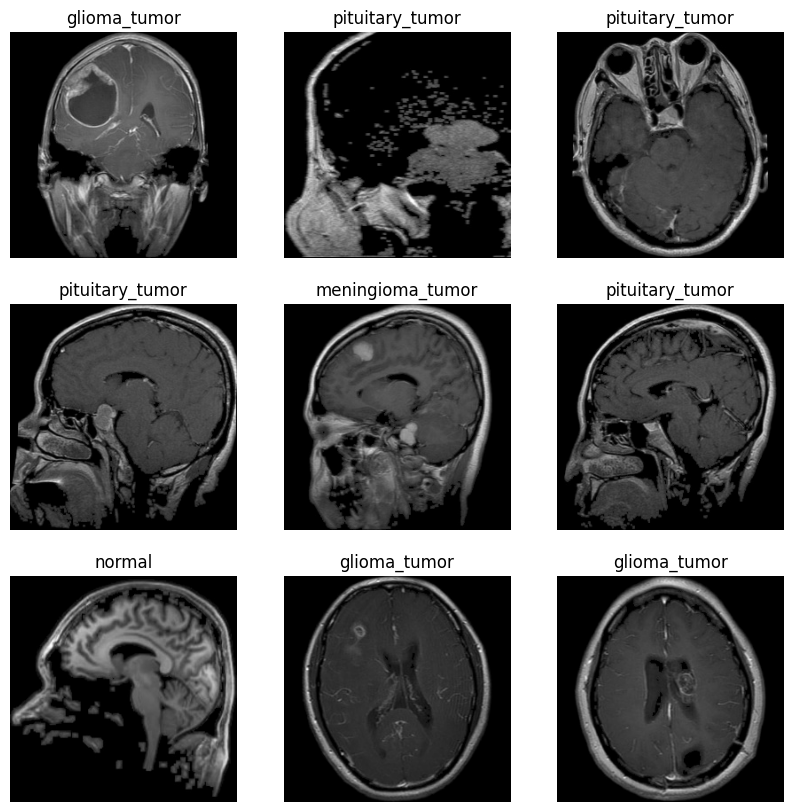

In [26]:
import matplotlib.pyplot as plt
import numpy as np

num = None
figsize = (10, 10)  # tamaño de la imagen
plt.figure(num, figsize)

# Conjunto de datos con 1 solo elemento
tensors = ds_train.take(1)

# Obtenemos las clases del conjunto de entrenamiento
classes = ds_train.class_names
classes = np.array(classes)

for images, labels in tensors:
    for i in range(9):
        # Transformamos el tensor a un array
        image = images[i]
        dtype = np.uint8  # Typecode al que casteamos el array
        image = np.array(image).astype(dtype)

        # Cogemos el label para la imagen que queremos printear
        label = labels[i]
        label = classes[label]

        # Printeamos la imagen
        rows = 3
        columns = 3
        index = i + 1
        option = "off"
        ax = plt.subplot(rows, columns, index)
        plt.imshow(image)
        plt.title(label)
        plt.axis(option)

### 4. Distribución de las clases

Como las clases están desbalanceadas (hay muchas menos instancias para el tumor normal), vamos a asignar pesos a cada clase, con el objetivo de dar mayor peso a las clases que tienen menor frecuencia de aparición. También, normalizaremos estos pesos. En este caso, la clase con menor frecuencia es el tipo de tumor normal, así que será el que más peso tenga.

meningioma_tumor
glioma_tumor
pituitary_tumor
normal
Pesos para cada clase:
------------------------------------
{'meningioma_tumor': 0.19298399393371107, 'glioma_tumor': 0.19548563829951845, 'pituitary_tumor': 0.20862103692043474, 'normal': 0.40290933084633573}
------------------------------------
Frecuencia de aparición de cada clase:


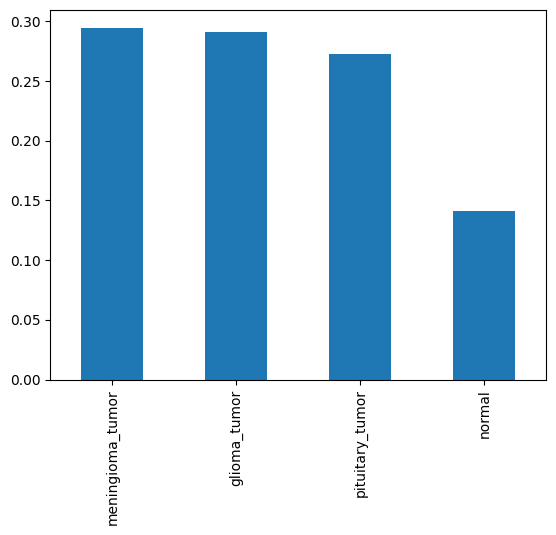

In [27]:
function = lambda file: file.split(os.sep)[2]
iterable = ds_train.file_paths
generator = map(function, iterable)

data = list(generator)  # Data to be stored
normalize = True  # Return the relative frequencies of the unique values
sort = True  # Sort by frequencies
kind = "bar"  # The kind of plot to produce
frecuencias = pd.Series(data).value_counts(normalize, sort)
#print(frecuencias)
weights = {}
cont = 0
total = 0
for clase,frec in frecuencias.items():
    valor = 1/frec
    weights[clase]= valor
    total += valor
    cont+=1
#print(weights)
#normalizamos pesos
class_weights = {}
cont = 0
for clase,w in weights.items():
    print(clase)
    class_weights[clase] = w/total
    cont+=1
class_indices = {clase: idx for idx, clase in enumerate(frecuencias.keys())}
mapped_class_weights = {class_indices[clase]: peso for clase, peso in class_weights.items()}
print("Pesos para cada clase:")
print("------------------------------------")
print(class_weights)
print("------------------------------------")
print("Frecuencia de aparición de cada clase:")
pd.Series(data).value_counts(normalize, sort).plot(kind = kind);

## 5. Análisis de intensidad de colores en las radiografías

> TODO: Histogramas de intensidad entre distintos tipos de tumores y picos de saturación, rango dinámico de mínimo, máximo y media de píxeles, y ver si hay varios escáneres por la diferencia en el brillo global

## 6. Obtención de la imagen promedio y la desviación

## 7. Análisis de textura por contraste, homogeneidad y entropía y obtención de bordes

## 8. Análisis de la separabilidad de las imágenes mediante PCA

## 9. Identificación de posibles outliers: imágenes recortadas

## 10. Pipeline final y transformaciones aplicables al conjunto de datos

Se aplicará aumentación de datos, puesto que el dataset no es demasiado grande, giro, etc etc